In [1]:
# https://www.tensorflow.org/tutorials/images/classification

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-12-17 09:26:14.858157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 09:26:15.769594: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/TensorRT-8.5.1.7/lib:
2022-12-17 09:26:15.769731: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/TensorRT-8.5.1.7/lib:
2022-12-17

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
# BIG FILE CANT PUSH IN GITHUB SO 
# MV DOWNLOADED FILE OUTSIDE
print(data_dir)

/home/krish/.keras/datasets/flower_photos


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


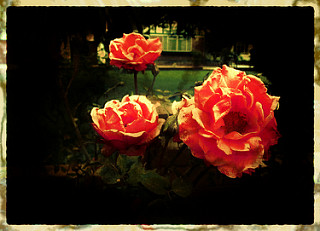

In [6]:
#Extract Rose 
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [7]:
## Some tulips

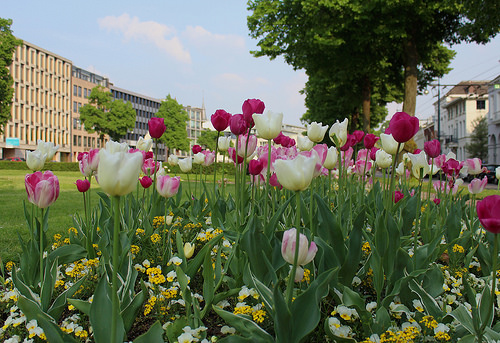

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

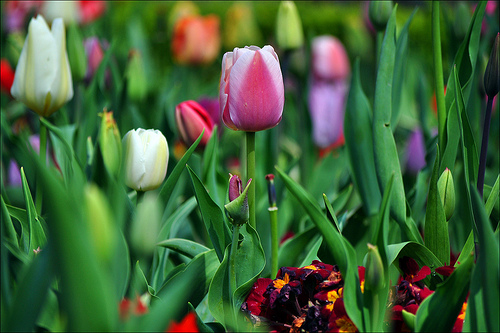

In [9]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras Utility

In [10]:
batch_size = 32
img_height = 180
img_width  = 180

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset = "training",
                                                      seed = 123,
                                                      image_size=(img_height, img_width),
                                                      batch_size= batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-12-17 09:26:17.119969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 09:26:17.199292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 09:26:17.199414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 09:26:17.201043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, 
                                                    validation_split=0.2,
                                                    subset = "validation",
                                                    seed = 123, 
                                                    image_size = (img_height, img_width),
                                                    batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the Data

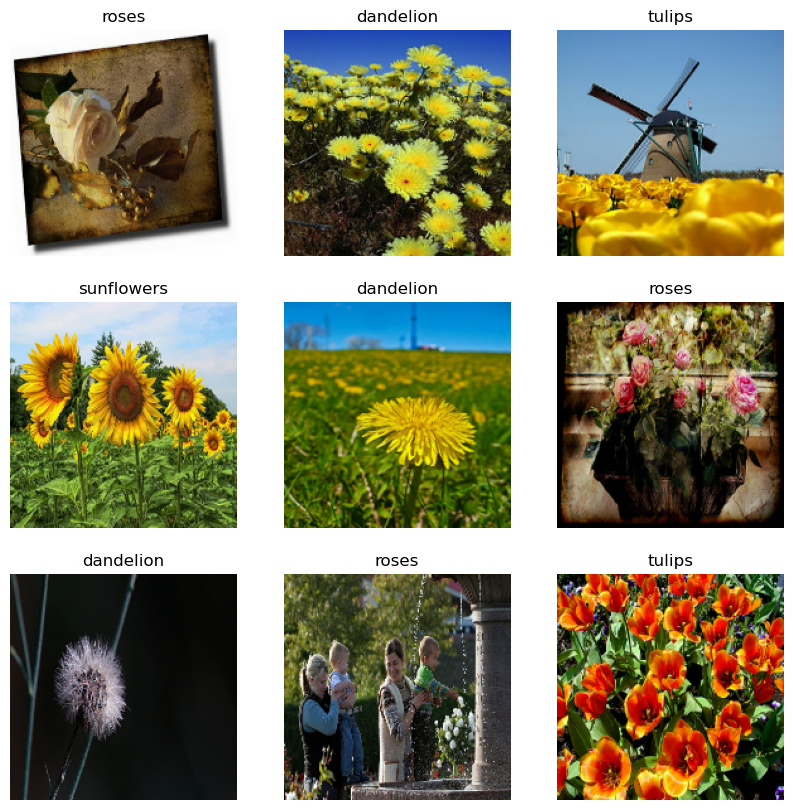

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Standardize the data

In [17]:
normalization_layer = layers.Rescaling(1. / 255)

In [18]:
normalized_ds = train_ds.map(lambda x,y : (normalization_layer(x),y))
image_batch , labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


### A basic Keras Model

In [19]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape = (img_height, img_width,3)),
    layers.Conv2D(16,3,padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32,3,padding = 'same', activation = "relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,3,padding = 'same', activation= "relu"),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    
    layers.Dense(num_classes)
    
])

In [20]:
## Compile the Model
model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the Model

In [22]:
epochs = 50

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50


2022-12-17 09:26:20.738486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2022-12-17 09:26:21.670326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-17 09:26:21.774535: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f24a1d5f420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-17 09:26:21.774551: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2022-12-17 09:26:21.787161: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-17 09:26:21.944863: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

92/92 [==============================] - 5s 14ms/step - loss: 1.3121 - accuracy: 0.4339 - val_loss: 1.0941 - val_accuracy: 0.5300
Epoch 2/50
92/92 [==============================] - 1s 10ms/step - loss: 0.9814 - accuracy: 0.6182 - val_loss: 0.9551 - val_accuracy: 0.6199
Epoch 3/50
92/92 [==============================] - 1s 10ms/step - loss: 0.7851 - accuracy: 0.6993 - val_loss: 0.8992 - val_accuracy: 0.6308
Epoch 4/50
92/92 [==============================] - 1s 10ms/step - loss: 0.5550 - accuracy: 0.7997 - val_loss: 0.9365 - val_accuracy: 0.6444
Epoch 5/50
92/92 [==============================] - 1s 10ms/step - loss: 0.3850 - accuracy: 0.8621 - val_loss: 1.0453 - val_accuracy: 0.6362
Epoch 6/50
92/92 [==============================] - 1s 10ms/step - loss: 0.2460 - accuracy: 0.9166 - val_loss: 1.2639 - val_accuracy: 0.6417
Epoch 7/50
92/92 [==============================] - 1s 10ms/step - loss: 0.1352 - accuracy: 0.9581 - val_loss: 1.3655 - val_accuracy: 0.6199
Epoch 8/50
92/92 [======

### Visualize Training Results

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range=range(epochs)
epochs_range = range(epochs)



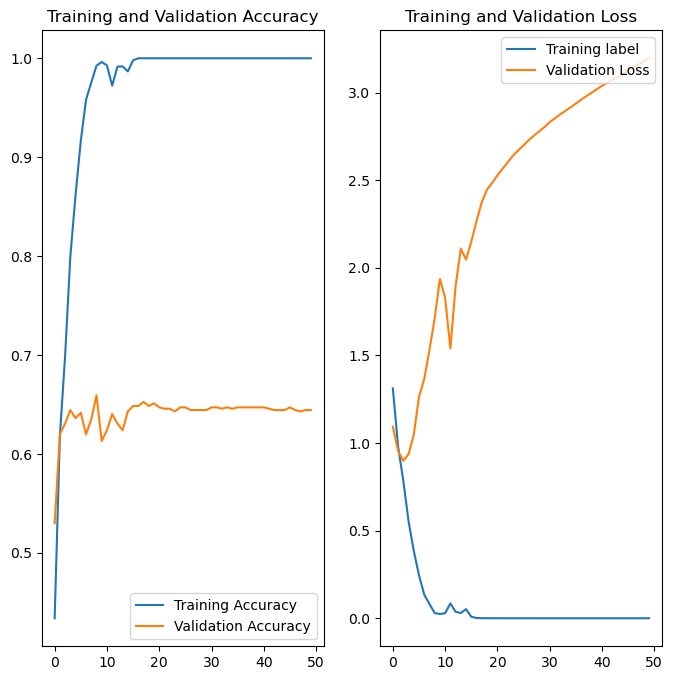

In [25]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = "Training Accuracy")
plt.plot(epochs_range , val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = "Training label")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

## Overfitting Problem

## Data Augmentation

In [26]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_height, img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

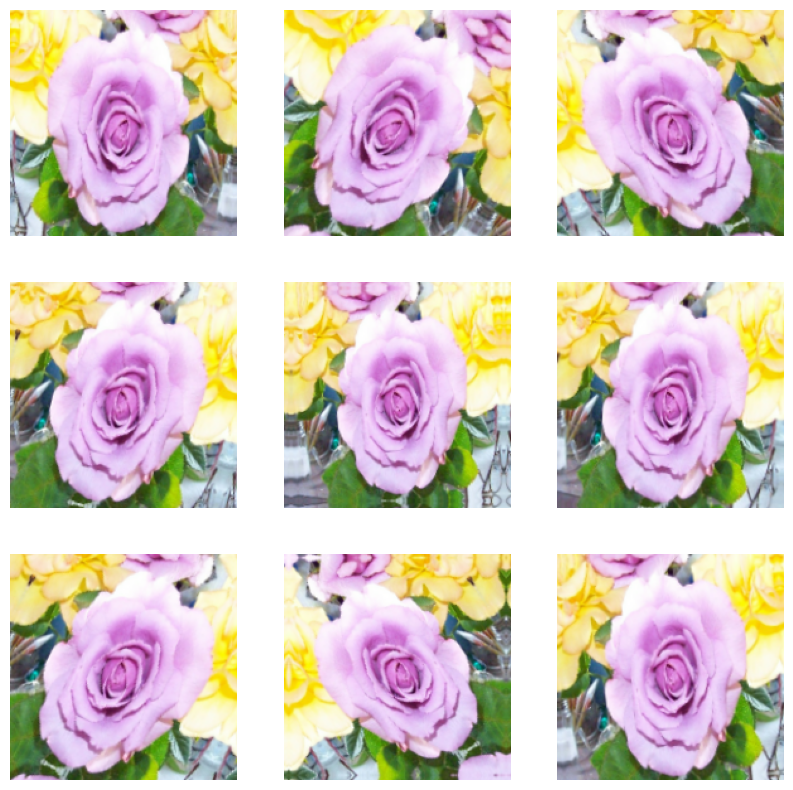

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

In [28]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32,3,padding='same' , activation = 'relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, name = "outputs")
])

## Compile the Model

In [29]:
model.compile(optimizer = "adam", 
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [31]:
epochs = 20 
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


2022-12-17 09:27:19.520226: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


92/92 [==============================] - 6s 43ms/step - loss: 1.2987 - accuracy: 0.4353 - val_loss: 1.2254 - val_accuracy: 0.5054
Epoch 2/20
92/92 [==============================] - 4s 42ms/step - loss: 1.0291 - accuracy: 0.5886 - val_loss: 1.1688 - val_accuracy: 0.5736
Epoch 3/20
92/92 [==============================] - 4s 42ms/step - loss: 0.9174 - accuracy: 0.6502 - val_loss: 1.0277 - val_accuracy: 0.6199
Epoch 4/20
92/92 [==============================] - 4s 42ms/step - loss: 0.8370 - accuracy: 0.6693 - val_loss: 0.8440 - val_accuracy: 0.6676
Epoch 5/20
92/92 [==============================] - 4s 42ms/step - loss: 0.7943 - accuracy: 0.6839 - val_loss: 0.8112 - val_accuracy: 0.6621
Epoch 6/20
92/92 [==============================] - 4s 42ms/step - loss: 0.7337 - accuracy: 0.7156 - val_loss: 0.8170 - val_accuracy: 0.6894
Epoch 7/20
92/92 [==============================] - 4s 42ms/step - loss: 0.6753 - accuracy: 0.7415 - val_loss: 0.8621 - val_accuracy: 0.6730
Epoch 8/20
92/92 [======

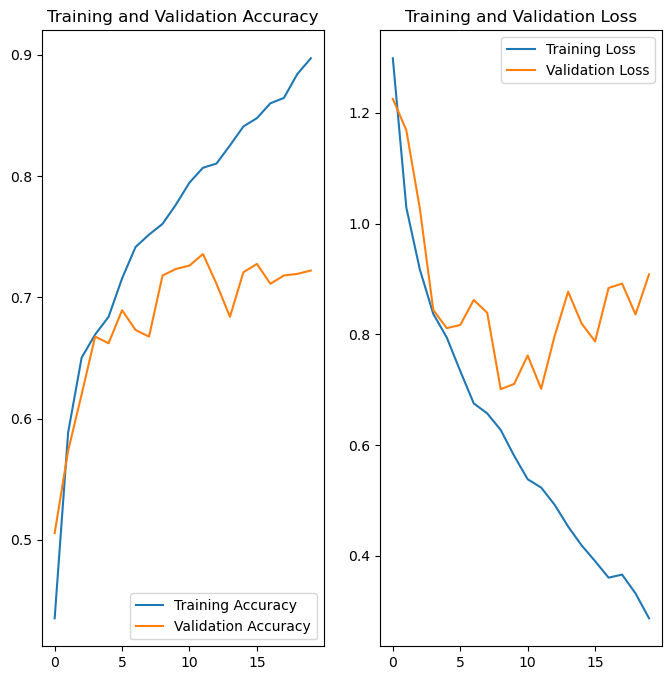

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [33]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 91ms/step
This image most likely belongs to sunflowers with a 99.12 percent confidence.
